In [0]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, timedelta
import warnings
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, fbeta_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
import joblib

pd.set_option("display.max_columns", None)

# Suppress all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load Dow Industrial historical data
data = pd.read_csv("/Workspace/Users/dzm0vy@nam.corp.gm.com/DJI.csv")

2024-11-26 16:24:25.646356: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 16:24:25.675335: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 16:24:25.675378: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 16:24:25.675415: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 16:24:25.682347: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 16:24:25.684114: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [0]:
# Extract day of week
data['DayOfWeek'] = pd.to_datetime(data["Date"]).dt.day_name()

# Rename columns
data.columns = ["date", "open", "high", "low", "close", "volume", "day"]
data["date"] = pd.to_datetime(data["date"]).dt.date
data.set_index("date", inplace=True)
data.index.name = None

# Reset index
data.index = pd.to_datetime(data.index)
data = data.reset_index()

data = data.rename(columns={"index":"date"})

# Eliminate all dates with zero volume
data = data.loc[data["volume"] > 0]

# Separate into 60-day groups
data["group"] = data.index // 60

# Keep only data from between first and last group to ensure even partitioning
data = data.loc[(data["group"] < max(data["group"])) & 
                (data["group"] > min(data["group"]))]

# Define number of periods
periods = data["group"].nunique()

In [0]:
# Calculate anomalies based on median absolute difference
def MAD_anomaly(group):
    sequence = group["close"]
    med = np.median(sequence)
    MAD = np.median(abs(sequence - med))
    threshold = 3 * 1.4826 * MAD 
    score = abs(sequence - med) / MAD
    group["MAD"] = np.where(score > (threshold / MAD), 1, 0)
    
    return group

# Calculate anomalies based on rolling Z-score over 60-day period
def rollingZ(group):
    sequence = group["close"]
    rolling_mean = sequence.rolling(window=60, min_periods=1).mean()
    rolling_std = sequence.rolling(window=60, min_periods=1).std()
    
    rollingZ = (sequence - rolling_mean) / rolling_std
    group["Z"] = np.where(abs(rollingZ) > 2.5, 1, 0)
    
    return group

In [0]:
data = data.groupby("group").apply(MAD_anomaly).reset_index(drop=True)
data = data.groupby("group").apply(rollingZ).reset_index(drop=True)

# Define an anomaly as one flagged by both MAD and rolling Z-score. MAD greater than rough equivalent of three standard deviations above MAD. Rolling Z-score greater than 2.5 standard deviations from mean.
data["anomaly"] = np.where((data["MAD"] == 1) & (data["Z"] == 1), 1, 0)

## Feature Engineering

In [0]:
# Calculate additional features
data["price_range"] = data["close"] - data["open"]
data["price_volume_ratio"] = data["close"] / data["volume"]
data["price_volume_interaction"] = data["close"] * data["volume"]
data['true_range'] = np.maximum(data['high'] - data['low'],
                            np.maximum(abs(data['high'] - data['close'].shift(1)),
                                       abs(data['low'] - data['close'].shift(1))))

In [0]:
# Calculate rolling features
def rolling(group):
    group["rolling_mean20"] = group["close"].rolling(window=20).mean()
    group["rolling_mean5"] = group["close"].rolling(window=5).mean()

    group["rolling_std20"] = group["close"].rolling(window=20).std()
    group["rolling_std5"] = group["close"].rolling(window=5).std()

    group["rolling_kurt20"] = group["close"].rolling(window=20).kurt()
    group["rolling_kurt5"] = group["close"].rolling(window=5).kurt()

    group["rolling_skew20"] = group["close"].rolling(window=20).skew()
    group["rolling_skew5"] = group["close"].rolling(window=5).skew()

    group["rolling_min20"] = group["close"].rolling(window=20).min()
    group["rolling_min5"] = group["close"].rolling(window=5).min()

    group["rolling_max20"] = group["close"].rolling(window=20).max()
    group["rolling_max5"] = group["close"].rolling(window=5).max()

    group["volume_mean20"] = group["volume"].rolling(window=20).mean()
    group["volume_mean5"] = group["volume"].rolling(window=5).mean()

    group["volume_std20"] = group["volume"].rolling(window=20).std()
    group["volume_std5"] = group["volume"].rolling(window=5).std()

    group["ewm_mean20"] = group["close"].ewm(span=20, adjust=False).mean()
    group["ewm_mean5"] = group["close"].ewm(span=5, adjust=False).mean()

    group["ewm_std20"] = group["close"].ewm(span=20, adjust=False).std()
    group["ewm_std5"] = group["close"].ewm(span=5, adjust=False).std()

    group["MACD"] = group["close"].ewm(span=10, adjust=False).mean() - group["close"].ewm(span=30, adjust=False).mean()
    group["signal_line"] = group["MACD"].ewm(span=9, adjust=False).mean()

    group["average_true20"] = group["true_range"].rolling(window=20).mean()
    group["average_true5"] = group["true_range"].rolling(window=5).mean()
    
    return group

# Define RSI
def RSI(group, window=15):
    delta = group['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gain / avg_loss

    group['RSI'] = 100 - (100 / (1 + rs))
    
    return group

# Define OBV
def OBV(group):
    group['OBV'] = 0

    for i in range(1, len(group)):
        if group['close'].iloc[i] > group['close'].iloc[i - 1]:
            group['OBV'].iloc[i] = group['OBV'].iloc[i - 1] + group['volume'].iloc[i]
        elif group['close'].iloc[i] < group['close'].iloc[i - 1]:
            group['OBV'].iloc[i] = group['OBV'].iloc[i - 1] - group['volume'].iloc[i]
        else:
            group['OBV'].iloc[i] = group['OBV'].iloc[i - 1]
    
    return group

# Define PVT
def PVT(group):
    group['PVT'] = 0.0
    
    for i in range(1, len(group)):
        price_change = (group['close'].iloc[i] - group['close'].iloc[i - 1]) / group['close'].iloc[i - 1]
        group['PVT'].iloc[i] = group['PVT'].iloc[i - 1] + (price_change * group['volume'].iloc[i])
    
    return group

# Define DMI
def DMI(group, period=15):
    # Calculate +DM and -DM
    group["pos_DM"] = np.where((group['high'] - group['high'].shift(1)) > (group['low'].shift(1) - group['low']),
                           np.maximum(group['high'] - group['high'].shift(1), 0), 0)
    group["neg_DM"] = np.where((group['low'].shift(1) - group['low']) > (group['high'] - group['high'].shift(1)),
                           np.maximum(group['low'].shift(1) - group['low'], 0), 0)
    
    # Smooth +DM, -DM, and TR using the period
    tr_smooth = group['true_range'].rolling(window=period).sum()
    pos_DM_smooth = group["pos_DM"].rolling(window=period).sum()
    neg_DM_smooth = group["neg_DM"].rolling(window=period).sum()
    
    # Calculate +DI and -DI
    group['+DI'] = (pos_DM_smooth / tr_smooth) * 100
    group['-DI'] = (neg_DM_smooth / tr_smooth) * 100
    
    group = group.drop(columns=["pos_DM", "neg_DM"])

    return group


def momentum(group, period=15):
    # Calculate momentum as the difference in price from `n` periods ago
    group["momentum"] = group['close'] - group['close'].shift(period)
    
    return group

In [0]:
# Create features based on functions
data = data.groupby("group").apply(rolling).reset_index(drop=True)
data = data.groupby("group").apply(RSI).reset_index(drop=True)
data = data.groupby("group").apply(OBV).reset_index(drop=True)
data = data.groupby("group").apply(PVT).reset_index(drop=True)
data = data.groupby("group").apply(DMI).reset_index(drop=True)
data = data.groupby("group").apply(momentum).reset_index(drop=True)

In [0]:
# Backfill NaNs
data = data.fillna(method="bfill")

# After backfilling NaNS:
data["returns"] = data["close"].pct_change()
data["volatility"] = data["returns"].rolling(window=10).std()
data["volatility_volume_corr"] = data["volatility"].corr(data["volume"])

# Backfill again
data = data.fillna(method="bfill")

In [0]:
# Define function for easily viewing performance metrics
def metrics(true_y, pred_y, proba=None):
  accuracy = accuracy_score(true_y, pred_y)
  precision = precision_score(true_y, pred_y)
  recall = recall_score(true_y, pred_y)
  fbeta = fbeta_score(true_y, pred_y, beta=0.1)
  roc_auc = roc_auc_score(true_y, proba)

  # Print results
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("Fbeta Score:", fbeta)
  print("ROC-AUC Score:", roc_auc)

In [0]:
# Define anomalies ('y' data)
y_long = np.array(data["anomaly"])
y_short = np.array(data.groupby("group")["anomaly"].any().astype(int).tolist())

# Prepare full data for training
day = np.array(data["day"]).reshape(-1, 1)
numerical = data.drop(columns=["date", "open", "high", "low", "day", "group", "MAD", "Z", "anomaly"])

scaler = StandardScaler()
OH = OneHotEncoder(sparse=False)

numerical_data = scaler.fit_transform(numerical)
categorical_data = OH.fit_transform(day)

X = np.concatenate([numerical_data, categorical_data], axis=1)
data_X = pd.DataFrame(X)
features = X.shape[1]

X_nn = X.reshape(periods, 60, features)

In [0]:
# Partition healthy and anomalous signals
anomalous_groups = data.loc[data["anomaly"] == 1, "group"].unique()
data_healthy = data.loc[~data["group"].isin(anomalous_groups)]  # 373 healthy groups

# Prepare healthy data for training
day = np.array(data_healthy["day"]).reshape(-1, 1)
numerical = data_healthy.drop(columns=["date", "open", "high", "low", "day", "group", "MAD", "Z", "anomaly"])

scaler = StandardScaler()
OH = OneHotEncoder(sparse=False)

numerical_healthy = scaler.fit_transform(numerical)
categorical_healthy = OH.fit_transform(day)

X_healthy = np.concatenate([numerical_healthy, categorical_healthy], axis=1)

X_healthy = X_healthy.reshape(373, 60, 46)
X_healthy_train, X_healthy_val = train_test_split(X_healthy, test_size=0.2, random_state=42)

degraded_samples = X_nn[y_short == 1][:8]  # Select only the degraded samples from X

X_test = np.concatenate([X_healthy_val, degraded_samples], axis=0)
y_test = np.concatenate([np.zeros(len(X_healthy_val)), np.ones(len(degraded_samples))])

In [0]:
# Obtain class weights to handle imbalance between healthy and degraded samples
from sklearn.utils.class_weight import compute_class_weight

classes = np.array([0, 1])
class_weights_manual = compute_class_weight(class_weight='balanced', classes=classes, y=y_short)
class_weights = {0: class_weights_manual[0], 1: class_weights_manual[1]}

In [0]:
class_weights

{0: 0.5536193029490617, 1: 5.1625}

## LSTM

In [0]:
timesteps = 60
features = 46
latent_dim = 64
output_size = 1

# Encoder
input_layer = Input(shape=(timesteps, features))
encoded = LSTM(latent_dim, activation='tanh')(input_layer)

# Decoder
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(latent_dim, activation='tanh', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(features))(decoded)

# Define Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

# Train Autoencoder on `X_healthy_train`
autoencoder.fit(X_healthy_train, X_healthy_train, epochs=50, verbose=0)

# Extract Latent Representations
encoder = Model(inputs=input_layer, outputs=encoded)

# Latent representations for `X_healthy_val` for threshold setting
latent_representations_val = encoder.predict(X_healthy_val)

# Calculate Reconstruction Error Threshold
# Get reconstruction error on `X_healthy_val`
reconstructed_val = autoencoder.predict(X_healthy_val)
reconstruction_errors_val = np.mean(np.square(X_healthy_val - reconstructed_val), axis=(1, 2))
threshold = np.percentile(reconstruction_errors_val, 95)  # Example threshold

# Prepare Latent Representations for Supervised Classification
# Obtain latent representations of the `X_nn` dataset
latent_representations_nn = encoder.predict(X_test)  
y_nn = np.concatenate([np.zeros(len(X_healthy_val)), np.ones(len(degraded_samples))])  # Binary labels for healthy and degraded in `X_nn`

# Add a Classification Layer
classification_input = Input(shape=(latent_representations_nn.shape[1],))
classifier = Dense(50, activation='tanh')(classification_input)
classifier = Dense(1, activation='sigmoid')(classifier)

# Define  Hybrid Model
hybrid_model = Model(inputs=classification_input, outputs=classifier)
hybrid_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train the Classifier on Latent Representations from Training Data
hybrid_model.fit(latent_representations_nn, y_nn, epochs=50, verbose=0)

# Predict Anomalies on `X_nn` Using Hybrid Model
predictions = hybrid_model.predict(latent_representations_nn)

threshold = 0.5
y_pred = (predictions >= threshold).reshape(-1).astype(float)

4/4 [==============================] - 0s 955us/step


In [0]:
metrics(y_test, y_pred, predictions)

Accuracy: 0.6347826086956522
Precision: 0.375
Recall: 0.075
Fbeta Score: 0.3607142857142857
ROC-AUC Score: 0.5010000000000001


In [0]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = 0.68)')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve: Baseline GRU Classifier')
plt.legend(loc='lower right')
plt.grid()
# plt.show()
plt.savefig("GRU_ROC.png")

youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold (Youden's Index): {optimal_threshold}")

# Alternatively, minimize the distance to (0,1)
distances = ((fpr**2) + ((1 - tpr)**2))**0.5
optimal_idx_dist = distances.argmin()
optimal_threshold_dist = thresholds[optimal_idx_dist]

print(f"Optimal Threshold (Min Distance): {optimal_threshold_dist}")

### LSTM Using Reconstruction Errors

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Input
from tensorflow.keras.optimizers import Adam

timesteps = 60 
features = 46
latent_dim = 64

# Encoder
input_layer = Input(shape=(timesteps, features))
encoded = LSTM(latent_dim, activation='tanh')(input_layer)

# Decoder
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(latent_dim, activation='tanh', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(features))(decoded)

# Define Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss='mse')

# Train Autoencoder on healthy data (0s only)
autoencoder.fit(X_healthy_train, X_healthy_train, epochs=50, verbose=0)

# Calculate Reconstruction Errors for Healthy Data
reconstructed_healthy = autoencoder.predict(X_healthy_val)
reconstruction_errors_healthy = np.mean(np.square(X_healthy_val - reconstructed_healthy), axis=(1, 2))

# Set Threshold for Anomaly Detection
threshold = np.percentile(reconstruction_errors_healthy, 90)  # 95th percentile threshold for healthy data

# Calculate Reconstruction Errors for New Data and Detect Anomalies
reconstructed_all = autoencoder.predict(X_test)  # Predict on new data
reconstruction_errors_all = np.mean(np.square(X_test - reconstructed_all), axis=(1, 2))  # MSE for each sample

# Classify as anomaly if reconstruction error is above the threshold
anomalies = (reconstruction_errors_all > threshold).astype(int)

In [0]:
metrics(y_test, anomalies, reconstruction_errors_all)

## GRU

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, RepeatVector, TimeDistributed, Dense, Input
from tensorflow.keras.optimizers import Adam

timesteps = 60
features = 46
latent_dim = 64
output_size = 1

# Encoder
input_layer = Input(shape=(timesteps, features))
encoded = GRU(latent_dim, activation='tanh')(input_layer) 

# Decoder
decoded = RepeatVector(timesteps)(encoded)
decoded = GRU(latent_dim, activation='tanh', return_sequences=True)(decoded) 
decoded = TimeDistributed(Dense(features))(decoded)

# Define Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

# Train Autoencoder on `X_healthy_train`
autoencoder.fit(X_healthy_train, X_healthy_train, epochs=50, verbose=0)

# Extract Latent Representations 
encoder = Model(inputs=input_layer, outputs=encoded)

# Latent representations for `X_healthy_val` for threshold setting
latent_representations_val = encoder.predict(X_healthy_val)

# Calculate Reconstruction Error Threshold 
# Get reconstruction error on `X_healthy_val`
reconstructed_val = autoencoder.predict(X_healthy_val)
reconstruction_errors_val = np.mean(np.square(X_healthy_val - reconstructed_val), axis=(1, 2))
threshold = np.percentile(reconstruction_errors_val, 95)  # Example threshold

# Prepare Latent Representations 
# Obtain latent representations of the `X_nn` dataset
latent_representations_nn = encoder.predict(X_test)  # Features for the classifier
y_nn = np.concatenate([np.zeros(len(X_healthy_val)), np.ones(len(degraded_samples))])  # Binary labels for healthy and degraded in `X_nn`

# Add a Classification Layer
classification_input = Input(shape=(latent_representations_nn.shape[1],))
classifier = Dense(50, activation='tanh')(classification_input)
classifier = Dense(1, activation='sigmoid')(classifier)

# Define the Hybrid Model
hybrid_model = Model(inputs=classification_input, outputs=classifier)
hybrid_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train the Classifier on Latent Representations from Training Data
# Use `latent_representations_val` and `y_nn` for training the classifier
hybrid_model.fit(latent_representations_nn, y_nn, epochs=50, verbose=0)

# Predict Anomalies on `X_nn` Using Hybrid Model
predictions = hybrid_model.predict(latent_representations_nn)

threshold = 0.5
y_pred = (predictions >= threshold).reshape(-1).astype(float)


In [0]:
metrics(y_test, y_pred, predictions)

### Transformer

In [0]:
from tensorflow.keras.layers import LayerNormalization, Dropout, MultiHeadAttention, Add, GlobalAveragePooling1D

timesteps = 60
features = 46
latent_dim = 64
output_size = 1
heads = 8
dropout = 0.1

# Define Transformer Encoder Layer
def transformer_encoder(inputs, num_heads=heads, latent_dim=latent_dim, dropout_rate=dropout):
    # Ensure that the feature dimensions stay consistent
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=features)(inputs, inputs)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = Add()([inputs, attn_output])
    out1 = LayerNormalization(epsilon=1e-6)(out1)
    
    # Feed-forward layer with feature dimension preserved
    ffn_output = Dense(features, activation="relu")(out1)
    ffn_output = Dense(features)(ffn_output)  # Ensure output dimension matches `features`
    ffn_output = Dropout(dropout_rate)(ffn_output)
    out2 = Add()([out1, ffn_output])
    return LayerNormalization(epsilon=1e-6)(out2)

# Define Transformer Decoder Layer
def transformer_decoder(encoded_inputs, num_heads=heads, latent_dim=latent_dim, dropout_rate=dropout):
    # Ensure that the feature dimensions stay consistent
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=features)(encoded_inputs, encoded_inputs)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = Add()([encoded_inputs, attn_output])
    out1 = LayerNormalization(epsilon=1e-6)(out1)
    
    # Feed-forward layer with feature dimension preserved
    ffn_output = Dense(features, activation="relu")(out1)
    ffn_output = Dense(features)(ffn_output)  # Ensure output dimension matches `features`
    ffn_output = Dropout(dropout_rate)(ffn_output)
    out2 = Add()([out1, ffn_output])
    return LayerNormalization(epsilon=1e-6)(out2)

# Encoder
input_layer = Input(shape=(timesteps, features))
encoder_output = transformer_encoder(input_layer, num_heads=heads, latent_dim=latent_dim)

# Pooling to reduce to latent dimension, making it compatible with RepeatVector
encoded = GlobalAveragePooling1D()(encoder_output)  # Shape: (batch_size, features)

# Decoder
decoded = RepeatVector(timesteps)(encoded)
decoded = transformer_decoder(decoded, num_heads=heads, latent_dim=latent_dim)
decoded_output = Dense(features)(decoded)   # Final output layer for reconstruction

# Define Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=decoded_output)
autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

# Train Autoencoder on Healthy Data
autoencoder.fit(X_healthy_train, X_healthy_train, epochs=50, verbose=0)

# Extract Latent Representations
# Define encoder model to produce latent representations for classification
encoder_model = Model(inputs=input_layer, outputs=encoded)
latent_representations_val = encoder_model.predict(X_healthy_val)

# Set Threshold for Anomaly Detection
# Calculate reconstruction errors on `X_healthy_val`
reconstructed_val = autoencoder.predict(X_healthy_val)
reconstruction_errors_val = np.mean(np.square(X_healthy_val - reconstructed_val), axis=(1, 2))
threshold = np.percentile(reconstruction_errors_val, 95)

# Prepare Latent Representations
# Obtain latent representations for `X_nn`
latent_representations_nn = encoder_model.predict(X_test)  # Features for the classifier
y_nn = np.concatenate([np.zeros(len(X_healthy_val)), np.ones(len(degraded_samples))])  # Binary labels for `X_nn`

# Add a Classification Layer 
classification_input = Input(shape=(latent_representations_nn.shape[1],))
classifier = Dense(50, activation='tanh')(classification_input)
classifier = Dense(1, activation='sigmoid')(classifier)

# Define the Hybrid Model
hybrid_model = Model(inputs=classification_input, outputs=classifier)
hybrid_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train Classifier on Latent Representations and Labels
hybrid_model.fit(latent_representations_nn, y_nn, epochs=50, verbose=0)

# Predict Anomalies on `X_nn` Using Hybrid Model
predictions = hybrid_model.predict(latent_representations_nn)

In [0]:
threshold = 0.5
y_pred = (predictions >= threshold).reshape(-1).astype(float)

metrics(y_test, y_pred, predictions)

## Better LSTM Using Class Weights and Tuned Threshold

In [0]:
class_weights

array([0.5536193, 5.1625   ])

In [0]:
timesteps = 60
features = 46
latent_dim = 64
output_size = 1

# Encoder
input_layer = Input(shape=(timesteps, features))
encoded = LSTM(512, activation='tanh', return_sequences=True, dropout=0.2)(input_layer)  # First LSTM layer
encoded = LSTM(256, activation='tanh', return_sequences=True, dropout=0.2)(input_layer)
encoded = LSTM(128, activation='relu', return_sequences=False, dropout=0.2)(encoded)      # Second LSTM layer (last in encoder)

# Decoder
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(128, activation='tanh', return_sequences=True)(decoded)
decoded = LSTM(256, activation='tanh', return_sequences=True)(decoded)       # First LSTM layer in decoder
decoded = LSTM(512, activation='tanh', return_sequences=True)(decoded)      # Second LSTM layer in decoder
decoded = TimeDistributed(Dense(features))(decoded)                         # Final output layer

# Define Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

# Train Autoencoder on `X_healthy_train`
autoencoder.fit(X_healthy_train, X_healthy_train, epochs=75, verbose=0)

# Extract Latent Representations 
encoder = Model(inputs=input_layer, outputs=encoded)

# Latent representations for `X_healthy_val` for threshold setting
latent_representations_val = encoder.predict(X_healthy_val)

# Calculate Reconstruction Error Threshold 
# Get reconstruction error on `X_healthy_val`
reconstructed_val = autoencoder.predict(X_healthy_val)
reconstruction_errors_val = np.mean(np.square(X_healthy_val - reconstructed_val), axis=(1, 2))
threshold = np.percentile(reconstruction_errors_val, 95)  # Example threshold

# Prepare Latent Representations
# Obtain latent representations of the `X_nn` dataset
latent_representations_nn = encoder.predict(X_test)  # Features for the classifier
y_nn = np.concatenate([np.zeros(len(X_healthy_val)), np.ones(len(degraded_samples))])  # Binary labels for healthy and degraded in `X_nn`

# Add a Classification Layer
classification_input = Input(shape=(latent_representations_nn.shape[1],))
classifier = Dense(100, activation='relu')(classification_input)
classifier = Dense(25, activation='tanh')(classifier)
classifier = Dense(1, activation='sigmoid')(classifier)

# Define the Hybrid Model
hybrid_model = Model(inputs=classification_input, outputs=classifier)
hybrid_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train the Classifier on Latent Representations
# Use `latent_representations_val` and `y_nn` for training the classifier
hybrid_model.fit(latent_representations_nn, y_nn, class_weight=class_weights, epochs=75, batch_size=10, verbose=0)

# Step 6: Predict Anomalies on `X_nn` Using Hybrid Model
predictions = hybrid_model.predict(latent_representations_nn)

3/3 [==============================] - 0s 1ms/step
Accuracy: 0.9518072289156626
Precision: 0.8333333333333334
Recall: 0.625
Fbeta Score: 0.8305921052631579
ROC-AUC Score: 0.9916666666666667


In [0]:
threshold = 0.879
y_pred = (predictions >= threshold).reshape(-1).astype(float)

metrics(y_test, y_pred, predictions)

Accuracy: 0.963855421686747
Precision: 1.0
Recall: 0.625
Fbeta Score: 0.9940944881889763
ROC-AUC Score: 0.9916666666666667


In [0]:
conf = confusion_matrix(y_test, y_pred)

In [0]:
conf

array([[75,  0],
       [ 3,  5]])

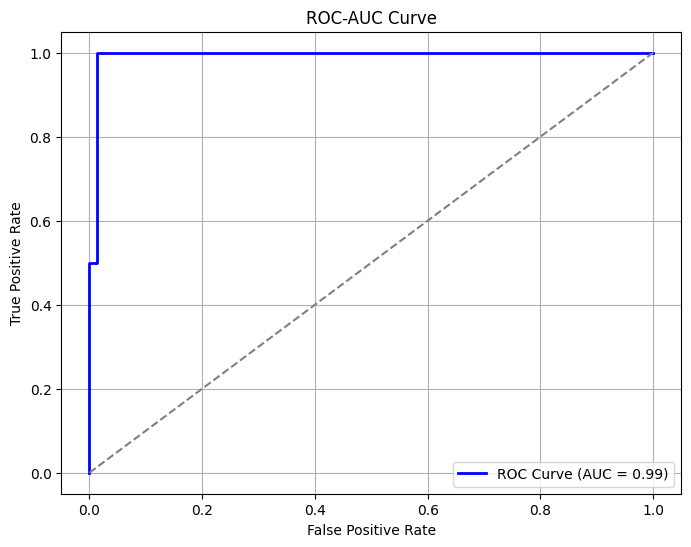

In [0]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.grid()
# plt.show()
plt.savefig("ROC-AUC.png")

In [0]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, predictions)

# Range of Beta Values to Tune
beta_values = np.linspace(0.1, 2, 20)  # Try values from 0.1 to 2
optimal_beta = None
best_fbeta_score = -np.inf
fbeta_scores = []

for beta in beta_values:
    # Calculate F_beta score for the range of thresholds
    f_beta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-9)
    max_fbeta = np.nanmax(f_beta_scores)  # Handle NaN cases
    fbeta_scores.append(max_fbeta)
    if max_fbeta > best_fbeta_score:
        best_fbeta_score = max_fbeta
        optimal_beta = beta

print(f"Optimal Beta: {optimal_beta}")
print(f"Best F_beta Score: {best_fbeta_score}")

Optimal Beta: 0.1
Best F_beta Score: 0.9901960764898117


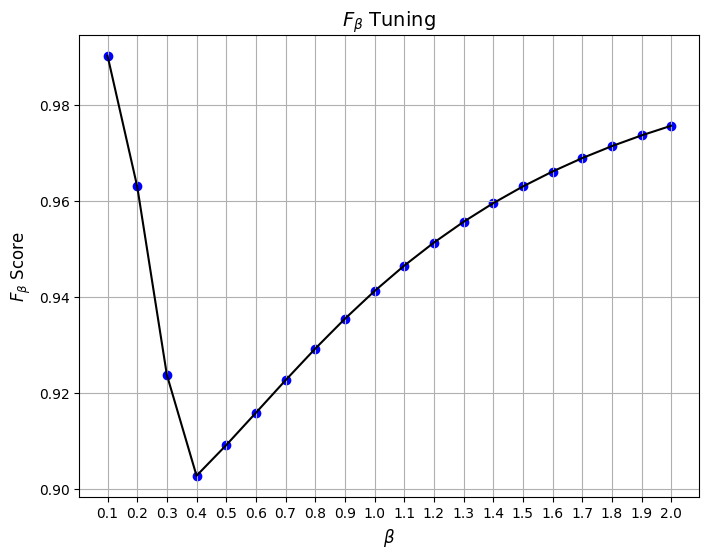

In [0]:
plt.figure(figsize=(8, 6))
plt.plot(beta_values, fbeta_scores, color='black') 
plt.scatter(beta_values, fbeta_scores, color='blue')  

plt.xlabel(r'$\beta$', fontsize=12)
plt.ylabel(r'$F_\beta$ Score', fontsize=12)

plt.title(r'$F_\beta$ Tuning', fontsize=14)

plt.xticks(np.linspace(0.1, 2, 20))

plt.grid()
# plt.show()
plt.savefig("fbeta.png")

In [0]:
precision, recall, thresholds = precision_recall_curve(y_test, predictions)

beta = 0.1

# Compute F_beta score for each threshold
f_beta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

# Find the optimal threshold
optimal_idx = f_beta_scores.argmax()
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Precision at Optimal Threshold: {precision[optimal_idx]}")
print(f"Recall at Optimal Threshold: {recall[optimal_idx]}")
print(f"F_beta Score at Optimal Threshold: {f_beta_scores[optimal_idx]}")

Optimal Threshold: 0.8794048428535461
Precision at Optimal Threshold: 1.0
Recall at Optimal Threshold: 0.625
F_beta Score at Optimal Threshold: 0.9940944881889763


In [0]:
thresholds

array([0.70233715, 0.7683008 , 0.77062416, 0.7741469 , 0.87016654,
       0.87940484, 0.89415795, 0.89571977, 0.90548784, 0.91886795],
      dtype=float32)

In [0]:
f_beta_scores[:10]

array([0.8015873 , 0.77863436, 0.75      , 0.8559322 , 0.83059211,
       0.99409449, 0.99019608, 0.98376623, 0.97115385, 0.93518519])

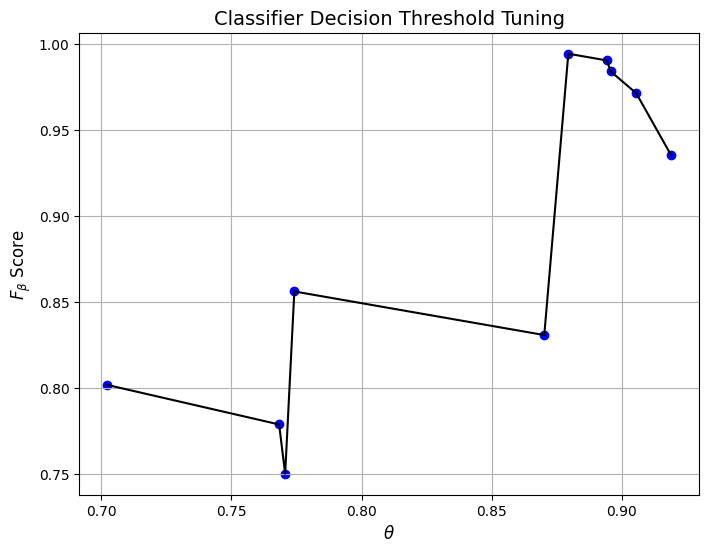

In [0]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f_beta_scores[:10], color='black') 
plt.scatter(thresholds, f_beta_scores[:10], color='blue')  

plt.xlabel(r"$\theta$", fontsize=12)
plt.ylabel(r'$F_\beta$ Score', fontsize=12)

plt.title("Classifier Decision Threshold Tuning", fontsize=14)

plt.grid()
# plt.show()
plt.savefig("threshold.png")

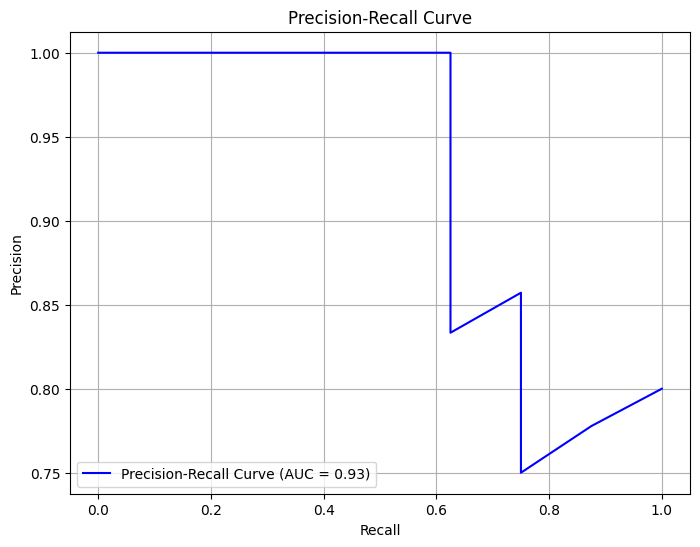

In [0]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, predictions)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="blue", label=f"Precision-Recall Curve (AUC = {average_precision:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.grid()
# plt.show()
plt.savefig("precision-recall.png")

In [0]:
cm = np.array([[74, 1], [1, 7]])

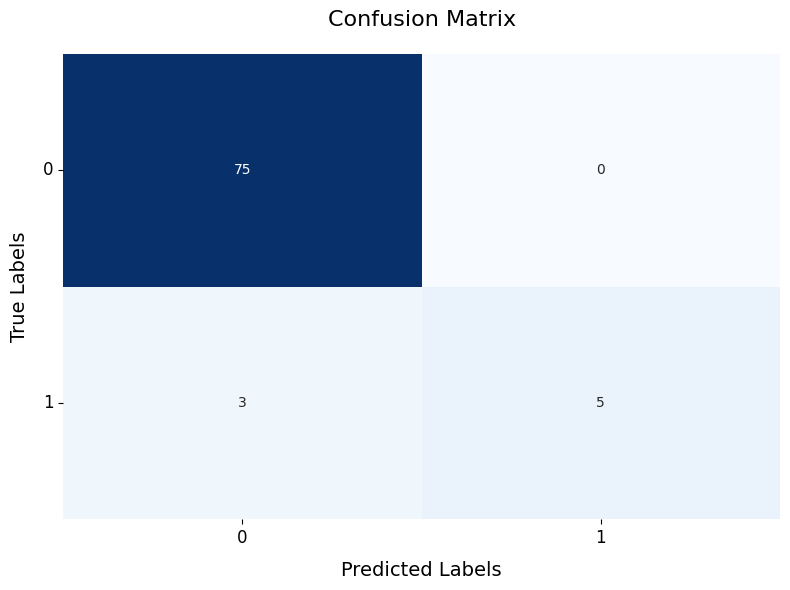

In [0]:
# Confusion matrix figure
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, cbar=False)

plt.xlabel("Predicted Labels", fontsize=14, labelpad=10)
plt.ylabel("True Labels", fontsize=14, labelpad=10)
plt.title("Confusion Matrix", fontsize=16, pad=20)


plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0) 

plt.tight_layout()
# plt.show()
plt.savefig("confusion.png")